In [1]:
import Base.show
using DataFrames
using Random

import Pkg
#Pkg.add("Graphs")
using Graphs

#Pkg.add("Plots")
using Plots

#Pkg.add("ColorSchemes")
using ColorSchemes

using Statistics

In [2]:
mutable struct Cohesin
    processivity::Int64
    alive::Int64
    left_pos::Int64
    right_pos::Int64
    left_blocked::Bool
    right_blocked::Bool
    left_ctcf_captured::Bool
    right_ctcf_captured::Bool
    extruded_beads::Array{Bool}
    
    function Cohesin(processivity, polymer_length, alive=0)
        loading_pos = rand(1:polymer_length)
        new(processivity, alive, loading_pos, loading_pos, false, false, false, false, fill(false, polymer_length))
    end
end
    
function Base.show(io::IO, object::Cohesin) 
        left_blocked_str = string((object.left_blocked) ? " (Cohesin blocked)" : "", 
                                  (object.left_ctcf_captured) ? " (CTCF captured)" : "")
        right_blocked_str = string((object.right_blocked) ? " (Cohesin blocked)" : "", 
                                   (object.right_ctcf_captured) ? " (CTCF captured)" : "") 
        print(io, string("Lived ", object.alive, " of ", object.processivity, " - "), 
                  string("Anchors: ", object.left_pos, left_blocked_str, ", ", object.right_pos, right_blocked_str, " - "), 
                  string("Extruded beads:", findall(object.extruded_beads), "\n")) 
end


In [3]:
mutable struct Sim
    polymer_length::Int64
    bead_size::Int64
    cohesins::Array{Cohesin}
    plus_ctcfs::DataFrame
    minus_ctcfs::DataFrame
    occupied_positions::Array{Bool}
    processivity::Float64
    ctcf_capture_rate::Float64
    ctcf_stabilization_factor::Int64
    extruded_beads::Array{Bool}
    bead_graph::SimpleGraph
    
    function Sim(n, polymer_length_bp=1e6, processivity_bp=150e3, bead_size = 1e3, 
                 ctcf_capture_rate=0.25, ctcf_stabilization_factor=4, plus_ctcfs=missing,
                 minus_ctcfs=missing)
        # Define polymer_length and processity in bead units
        polymer_length = Int(polymer_length_bp/bead_size)
        processivity = processivity_bp / bead_size
        occupied_positions = fill(false, polymer_length)
        alive = 0
        cohesins = []
        bead_graph = path_graph(polymer_length)
        for i in 1:n
            collision = true
            while (collision) 
                global coh = Cohesin(processivity, polymer_length, alive)
                if (!occupied_positions[coh.left_pos])
                    collision = false
                end
            end
            occupied_positions[coh.left_pos] = true
            alive = round(alive + processivity/n)
            push!(cohesins, coh)
            add_edge!(bead_graph, coh.left_pos, copy(coh.left_pos))
        end
        empty_ctcf_df = DataFrame(pos_bp=Float64[], pos=Int64[], occupancy_rate=Float64[], bound_cohesin=Bool[])
        if ismissing(plus_ctcfs)
            plus_ctcfs = deepcopy(empty_ctcf_df)
        end
        if ismissing(minus_ctcfs)
            minus_ctcfs = deepcopy(empty_ctcf_df)
        end
        new(polymer_length, bead_size, cohesins, plus_ctcfs, minus_ctcfs, occupied_positions, 
            processivity, ctcf_capture_rate, ctcf_stabilization_factor, fill(false, polymer_length), bead_graph)            
    end
end

function Base.show(io::IO, object::Sim)
    print(io, string("Cohesin positions: ", findall(object.occupied_positions), "\n"),
              string("Extruded beads: ", sum(object.extruded_beads), " of ", object.polymer_length, "\n"),
              string("Plus CTCF positions (bound fraction): ", object.plus_ctcfs.pos_bp, 
                        "(", object.plus_ctcfs.occupancy_rate, ") ", "\n"),
              string("Minus CTCF positions (bound fraction): ", object.minus_ctcfs.pos_bp, 
                        "(", object.minus_ctcfs.occupancy_rate, ") ", "\n"), "Individual cohesins:")
    for coh in object.cohesins 
        show(coh)
    end
end

In [4]:
function add_ctcf(object::Sim, orientation, pos_bp, occupancy_rate=1) 
    if orientation=="+" 
        push!(object.plus_ctcfs, (pos_bp, ceil(pos_bp/object.bead_size), occupancy_rate, false))
        sort!(object.plus_ctcfs, :pos_bp, rev=true)
    end
    if orientation=="-"
        push!(object.minus_ctcfs, (pos_bp, ceil(pos_bp/object.bead_size), occupancy_rate, false))
        sort!(object.minus_ctcfs, :pos_bp, rev=false)
    end
    object
end

add_ctcf (generic function with 2 methods)

In [5]:
function delete_ctcf(object::Sim, pos_bp)
    idx = indexin(pos_bp, object.plus_ctcfs.pos_bp)[1]
    if idx != nothing
        delete!(object.plus_ctcfs, [idx])
    end
    idx = indexin(pos_bp, object.minus_ctcfs.pos_bp)[1]
    if idx != nothing
        delete!(object.minus_ctcfs, [idx])
    end
    object
end

delete_ctcf (generic function with 1 method)

In [6]:
function advance(object::Sim)
    occupied_positions = object.occupied_positions
    for i in 1:length(object.cohesins)
        coh = object.cohesins[i]
        coh.alive += 1
        if coh.alive >= coh.processivity
            # println("Cohesin fell off!")
            if coh.left_pos+1 != coh.right_pos
                rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
            end
            occupied_positions[coh.left_pos] = false
            occupied_positions[coh.right_pos] = false
            # Release CTCF (if any)
            idx = indexin(coh.left_pos, object.plus_ctcfs.pos)[1]
            if idx != nothing
                object.plus_ctcfs.bound_cohesin[idx] = false
            end
            idx = indexin(coh.right_pos, object.minus_ctcfs.pos)[1]
            if idx != nothing
                object.minus_ctcfs.bound_cohesin[idx] = false
            end
            # Generate a new one (making sure it doesn't overlap an existing one)
            collision = true
            while (collision)
                coh = Cohesin(object.processivity, object.polymer_length)
                if (!occupied_positions[coh.left_pos])
                    collision = false
                end
            end
            occupied_positions[coh.left_pos] = true
            add_edge!(object.bead_graph, coh.left_pos, copy(coh.left_pos)) 
        else
            # LEFT
            new_left = coh.left_pos - 1
            if (!coh.left_ctcf_captured)
                # Left side captured by a CTCF?
                for idx in findall((object.plus_ctcfs.pos .== new_left) .& (object.plus_ctcfs.bound_cohesin .== false))
                    if rand(Float64) < object.plus_ctcfs.occupancy_rate[idx] * object.ctcf_capture_rate
                        # println("Captured!")
                        object.plus_ctcfs.bound_cohesin[idx] = true
                        coh.left_ctcf_captured = true
                        coh.processivity = object.processivity * object.ctcf_stabilization_factor
                    end
                end
                if (new_left>=1) 
                    if (occupied_positions[new_left]==false)
                        coh.left_blocked = false
                        if coh.left_pos != coh.right_pos
                            occupied_positions[coh.left_pos] = false
                        end
                        if coh.left_pos+1 != coh.right_pos
                            rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
                        end
                        add_edge!(object.bead_graph, new_left, coh.right_pos)
                        coh.left_pos = new_left
                        occupied_positions[new_left] = true
                    end
                else
                    coh.left_blocked = true
                end
            end
            # RIGHT
            new_right = coh.right_pos + 1
            if (!coh.right_ctcf_captured)
                # Right side captured by a CTCF?
                for idx in findall((object.minus_ctcfs.pos .== new_right) .& (object.minus_ctcfs.bound_cohesin .== false))
                    if rand(Float64) < object.minus_ctcfs.occupancy_rate[idx] * object.ctcf_capture_rate
                        # println("Captured!")
                        object.minus_ctcfs.bound_cohesin[idx] = true
                        coh.right_ctcf_captured = true
                        coh.processivity = object.processivity * object.ctcf_stabilization_factor
                    end
                end
                if (new_right<=object.polymer_length)
                    if (occupied_positions[new_right]==false)
                        coh.right_blocked = false
                        if coh.left_pos != coh.right_pos
                            occupied_positions[coh.right_pos] = false
                        end
                        if coh.left_pos+1 != coh.right_pos
                            rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
                        end
                        add_edge!(object.bead_graph, coh.left_pos, new_right)
                        coh.right_pos = new_right
                        occupied_positions[new_right] = true
                    end
                else
                    coh.right_blocked = true
                end
            end
            if coh.right_pos - coh.left_pos >= 2
                coh.extruded_beads[((coh.left_pos+1):(coh.right_pos-1))] .= true
            end
        end
        object.cohesins[i] = coh
    end
    object.occupied_positions = occupied_positions
    extruded_beads_sum = fill(false, object.polymer_length)
    for coh in object.cohesins
        extruded_beads_sum = extruded_beads_sum .| coh.extruded_beads
    end
    object.extruded_beads = extruded_beads_sum
    object
end

advance (generic function with 1 method)

In [7]:
function effective_dist(object::Sim)
    mat = transpose(dijkstra_shortest_paths(object.bead_graph, 1).dists)
    for i in 2:object.polymer_length
        mat = vcat(mat, transpose(dijkstra_shortest_paths(object.bead_graph, i).dists))
    end
    mat
end

effective_dist (generic function with 1 method)

In [8]:
function plot_fiber(object::Sim, xmin=nothing, xmax=nothing, main=nothing)
    x_list = [i for i in 1:object.polymer_length]
    y_list = map(x -> (x ? 2 : 1), object.extruded_beads)
    palette = ColorSchemes.Set1_9
    color_list = [ColorSchemes.grays[1] for i in 1:object.polymer_length]
    shape_list = [:circle for i in 1:object.polymer_length]
    for i in 1:length(object.cohesins) 
        col = palette[i]
        coh = object.cohesins[i]
        color_list[coh.left_pos] = col
        color_list[coh.right_pos] = col
        if coh.left_blocked
            shape_list[coh.left_pos] = :square
        end
        if coh.left_ctcf_captured
            shape_list[coh.left_pos] = :rtriangle
        end
        if coh.right_blocked
            shape_list[coh.right_pos] = :square
        end
        if coh.right_ctcf_captured
            shape_list[coh.right_pos] = :ltriangle
        end
    end
    if isnothing(xmin)
        xmin = (-2)
    end
    if isnothing(xmax)
        xmax = length(object.extruded_beads)+2
    end
    p = scatter(x_list, y_list, color=color_list, markershape=shape_list, label="", markersize=10, markerstrokewidth=0, 
        xlimits=(xmin,xmax), ylimits=(0,5))
    
    for i in 1:length(object.cohesins)
        col = palette[i]
        coh = object.cohesins[i]
        annotate!(mean([coh.left_pos, coh.right_pos]), 2.5+i*0.7, 
            text(string("Cohesin ", i, "\n(", coh.alive, " of ", coh.processivity, ")"), col, :center, 9))
    end
    if ((nrow(object.plus_ctcfs) + nrow(object.minus_ctcfs)) > 0 )
        ctcf_plot_df = [object.plus_ctcfs; object.minus_ctcfs]
        ctcf_plot_df.pch = [[">" for i in 1:nrow(object.plus_ctcfs)]; ["<" for i in 1:nrow(object.minus_ctcfs)]]
        ctcf_plot_df = groupby(ctcf_plot_df, :pos)
        ctcf_plot_df = combine(ctcf_plot_df, :pos, eachindex => :y, :pch)
        for i in 1:nrow(ctcf_plot_df)
            annotate!(ctcf_plot_df.pos[i], 0.25*ctcf_plot_df.y[i], text(ctcf_plot_df.pch[i], :center, 12))
        end
    end
    p
end

plot_fiber (generic function with 4 methods)

In [9]:
default(size = (900, 300))

# Test example:

In [10]:
Random.seed!(1234)
object = Sim(2, 50e3, 10e3, 1000, 0.9, 4)

object = add_ctcf(object, "+", 15000, 1)
object = add_ctcf(object, "+", 15005, 1)
object = add_ctcf(object, "+", 15010, 1)
object = add_ctcf(object, "-", 30000, 1)
object = add_ctcf(object, "-", 30005, 1)
object = add_ctcf(object, "-", 30010, 1)

object

Cohesin positions: [17, 28]
Extruded beads: 0 of 50
Plus CTCF positions (bound fraction): [15010.0, 15005.0, 15000.0]([1.0, 1.0, 1.0]) 
Minus CTCF positions (bound fraction): [30000.0, 30005.0, 30010.0]([1.0, 1.0, 1.0]) 
Individual cohesins:

Lived 0 of 10 - Anchors: 17, 17 - Extruded beads:Int64[]
Lived 5 of 10 - Anchors: 28, 28 - Extruded beads:Int64[]


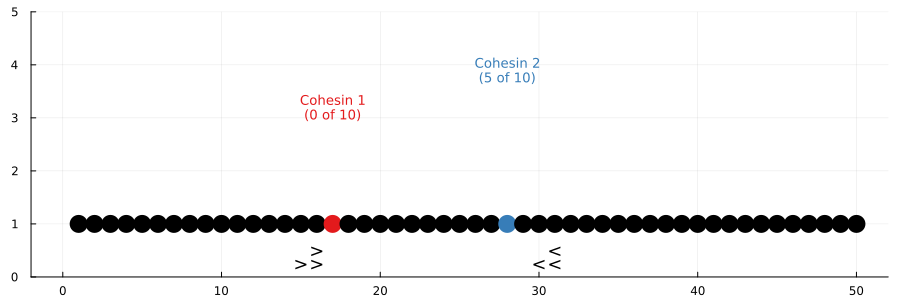

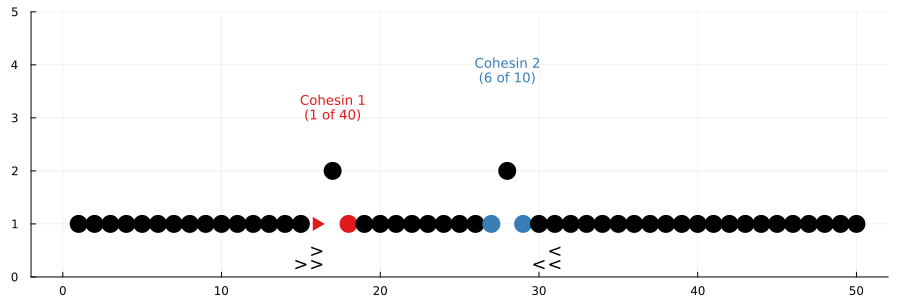

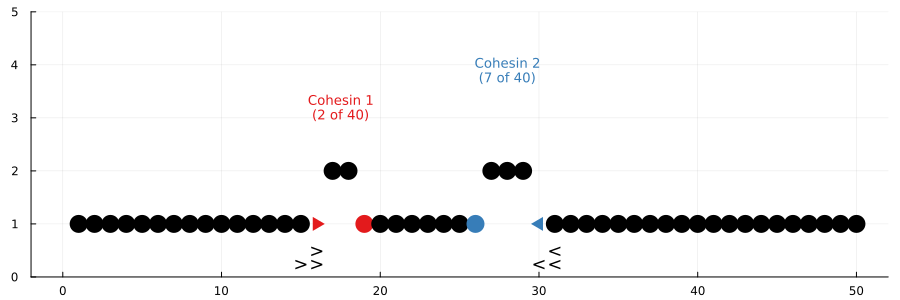

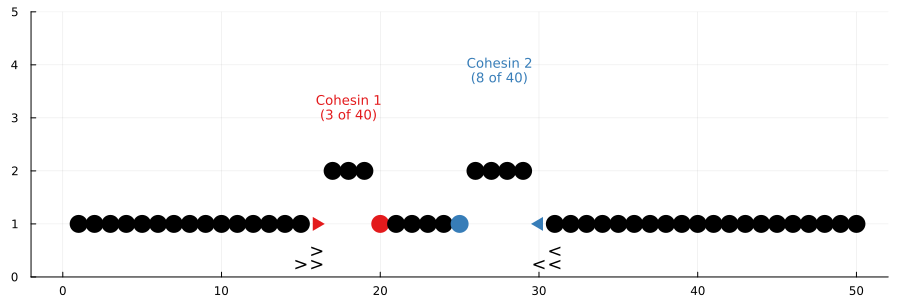

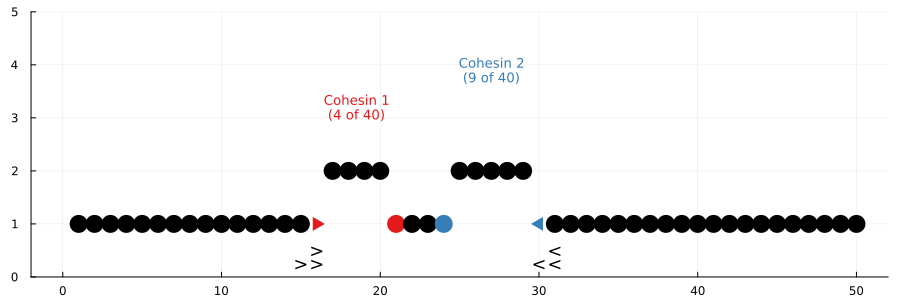

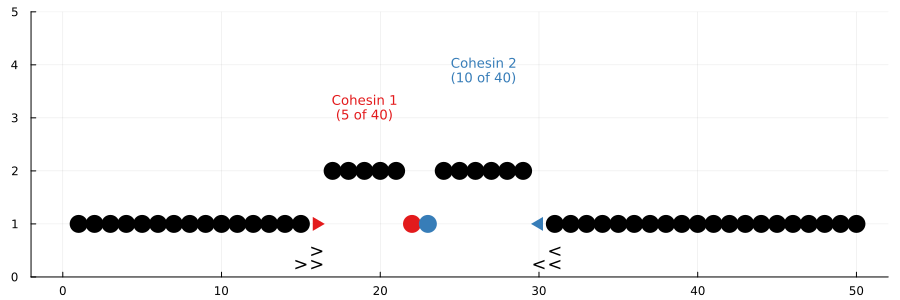

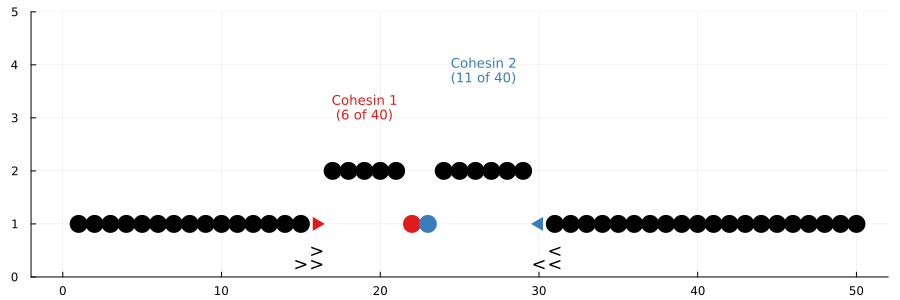

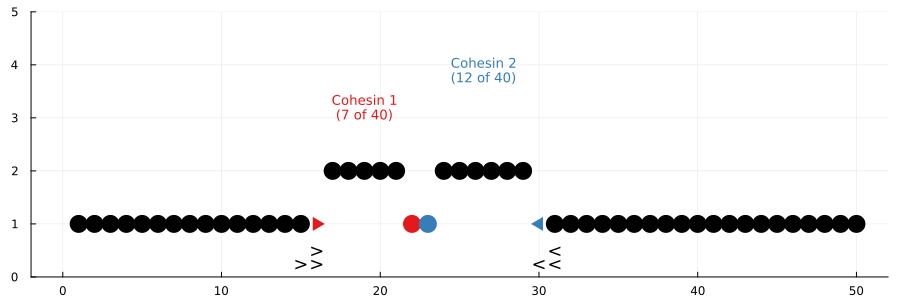

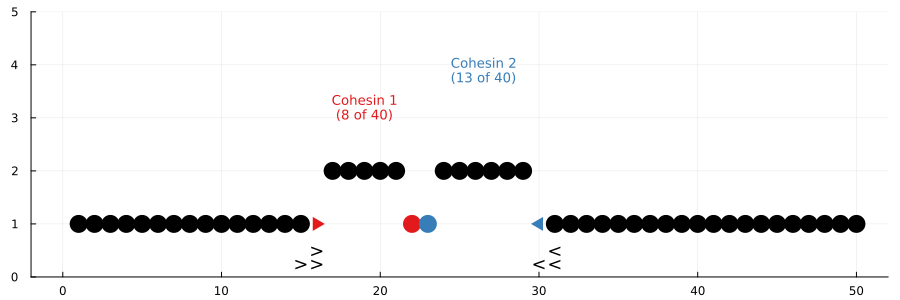

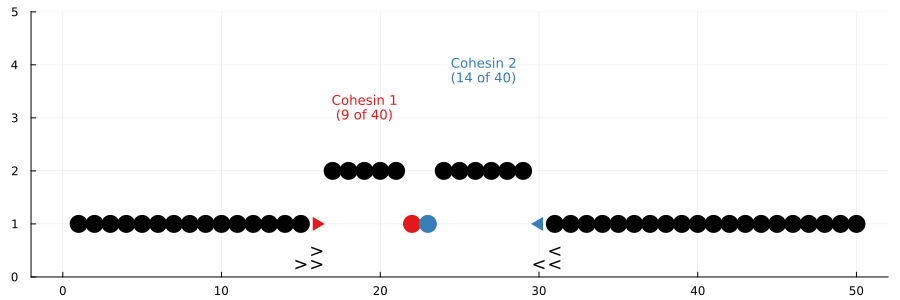

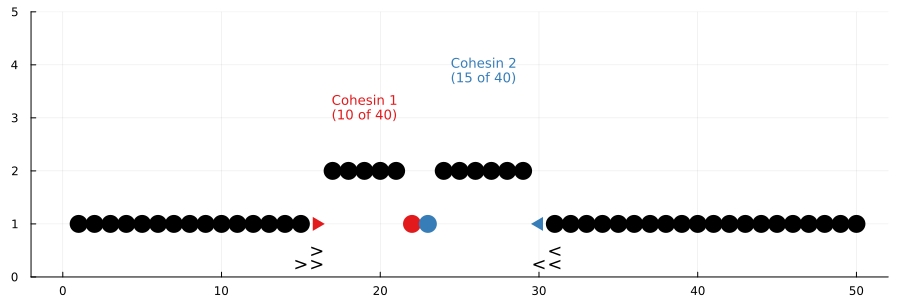

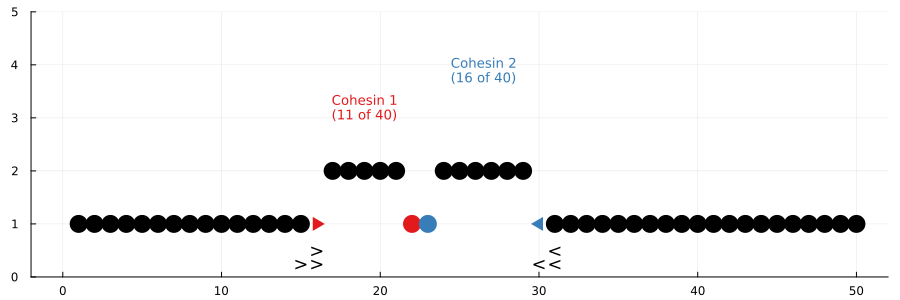

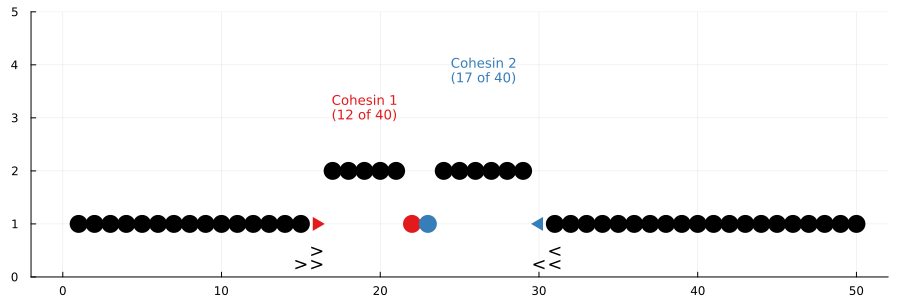

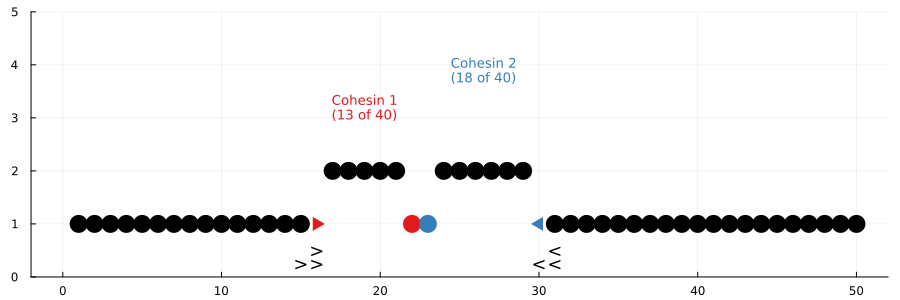

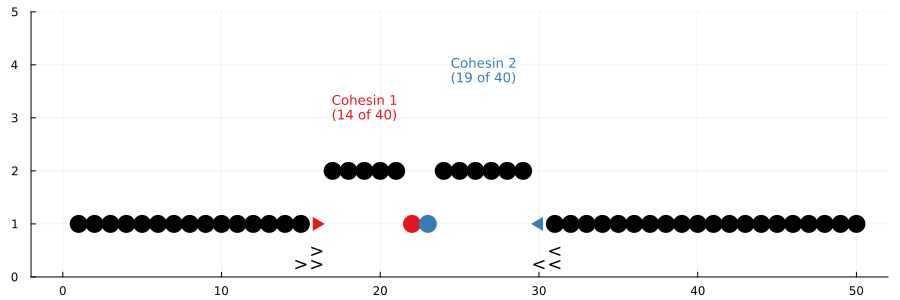

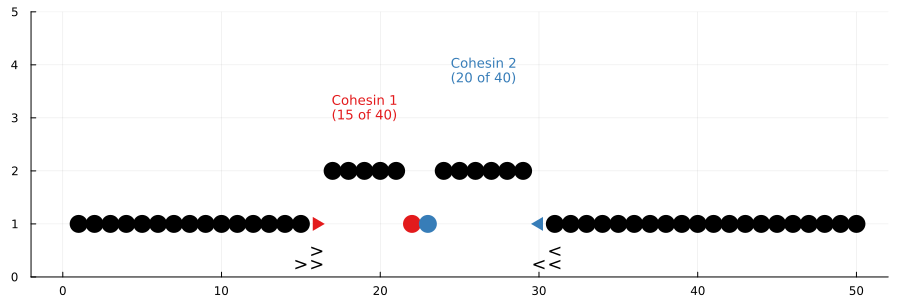

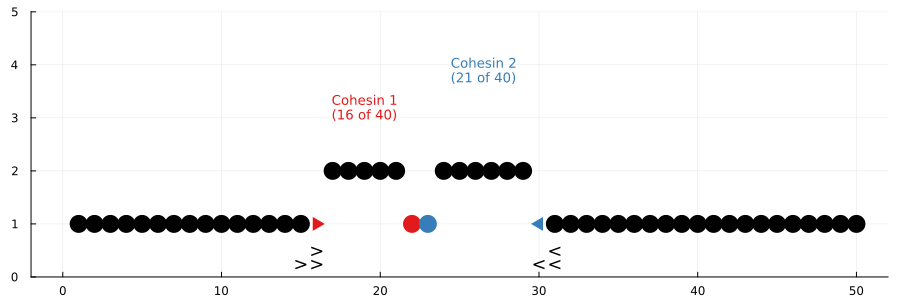

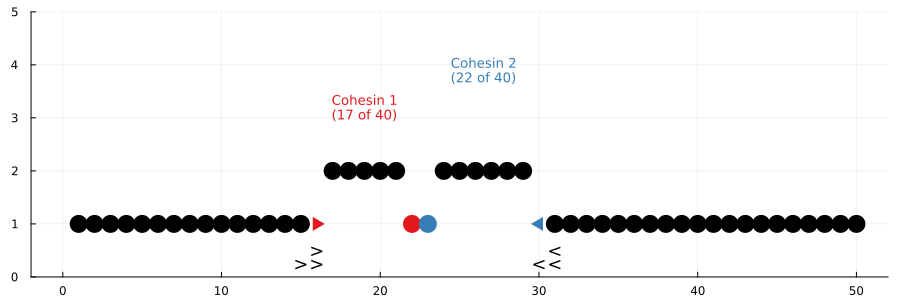

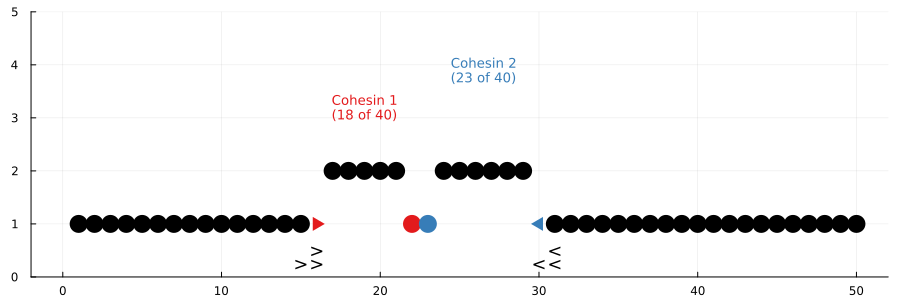

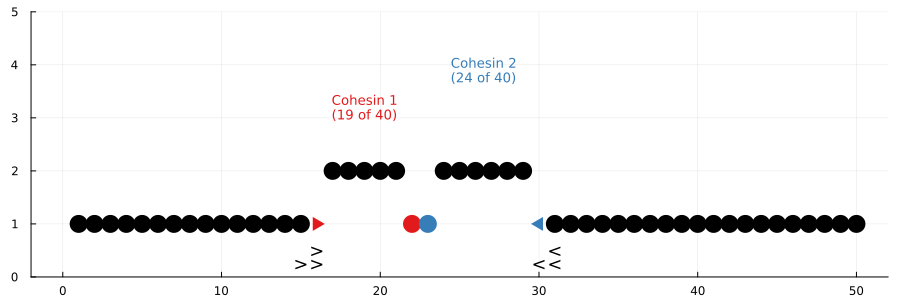

50×50 Matrix{Float64}:
 0.1        0.0909091  0.0833758  …  0.0251207  0.0247027  0.0242982
 0.0909091  0.1        0.0909091     0.0255359  0.0251073  0.0246925
 0.0833758  0.0909091  0.1           0.025964   0.0255244  0.0250991
 0.0771135  0.083353   0.0909091     0.0264124  0.0259611  0.0255246
 0.0718816  0.0770334  0.0833504     0.0268884  0.0264245  0.0259759
 0.0675068  0.0717501  0.0769838  …  0.0273957  0.0269183  0.0264568
 0.0638432  0.0673395  0.0716336     0.0279387  0.0274464  0.026971
 0.0607281  0.0636431  0.0671707     0.0285336  0.0280241  0.0275327
 0.0580586  0.0604909  0.0634229     0.02918    0.0286511  0.0281415
 0.0557317  0.0578191  0.0602426     0.0298807  0.0293298  0.0287998
 0.0536368  0.0554772  0.0575539  …  0.0306453  0.0300696  0.0295167
 0.0517389  0.0533948  0.0552209     0.031484   0.03088    0.0303014
 0.0500322  0.0515404  0.0531871     0.0324001  0.0317644  0.031157
 ⋮                                ⋱                        
 0.0302245  0.030764  

In [11]:
dists = effective_dist(object)
contacts = (effective_dist(object).+10).^(-1)
a=10
b=40
dists_a_to_b = [effective_dist(object)[a,b]]
for i in 1:20000
    # plot the first 20 steps in the simulation
    if i<=20
        display(plot_fiber(object))
    end
    advance(object)
    dists = dists + effective_dist(object)
    contacts = contacts + ((effective_dist(object).+10).^(-1))
    dists_a_to_b = push!(dists_a_to_b, effective_dist(object)[a,b])
end
dists = dists/20001
contacts = contacts/20001

In [12]:
# Average effective distances between points over the duration of the simulation
dists

50×50 Matrix{Float64}:
  0.0       1.0       1.9944    2.9714   …  31.0952   31.7774   32.475
  1.0       0.0       1.0       1.9974      30.4026   31.0847   31.7824
  1.9944    1.0       0.0       1.0         29.7282   30.4103   31.1079
  2.9714    1.9974    1.0       0.0         29.0592   29.7413   30.4389
  3.92435   2.9829    1.99775   1.0         28.3827   29.0648   29.7625
  4.84476   3.9445    2.99055   1.9979   …  27.6951   28.3772   29.0748
  5.72906   4.87116   3.964     2.9902      26.9946   27.6767   28.3743
  6.58277   5.76016   4.90105   3.97035     26.2699   26.9521   27.6497
  7.40448   6.61892   5.80096   4.92435     25.5272   26.2093   26.9069
  8.20329   7.43863   6.66667   5.83926     24.7708   25.4529   26.1505
  8.99245   8.23674   7.48843   6.71386  …  23.998    24.6801   25.3777
  9.77386   9.0222    8.28464   7.53592     23.2029   23.8851   24.5827
 10.5394    9.79156   9.05865   8.32253     22.3897   23.0718   23.7695
  ⋮                                      ⋱

In [13]:
contacts

50×50 Matrix{Float64}:
 0.1        0.0909091  0.0833758  …  0.0251207  0.0247027  0.0242982
 0.0909091  0.1        0.0909091     0.0255359  0.0251073  0.0246925
 0.0833758  0.0909091  0.1           0.025964   0.0255244  0.0250991
 0.0771135  0.083353   0.0909091     0.0264124  0.0259611  0.0255246
 0.0718816  0.0770334  0.0833504     0.0268884  0.0264245  0.0259759
 0.0675068  0.0717501  0.0769838  …  0.0273957  0.0269183  0.0264568
 0.0638432  0.0673395  0.0716336     0.0279387  0.0274464  0.026971
 0.0607281  0.0636431  0.0671707     0.0285336  0.0280241  0.0275327
 0.0580586  0.0604909  0.0634229     0.02918    0.0286511  0.0281415
 0.0557317  0.0578191  0.0602426     0.0298807  0.0293298  0.0287998
 0.0536368  0.0554772  0.0575539  …  0.0306453  0.0300696  0.0295167
 0.0517389  0.0533948  0.0552209     0.031484   0.03088    0.0303014
 0.0500322  0.0515404  0.0531871     0.0324001  0.0317644  0.031157
 ⋮                                ⋱                        
 0.0302245  0.030764  

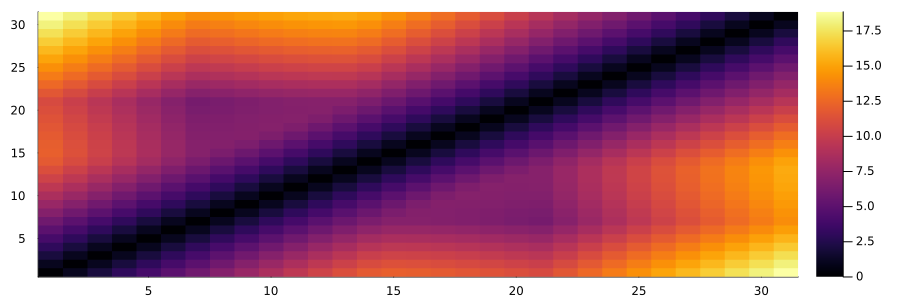

In [14]:
plot(heatmap(dists[10:40,10:40]))

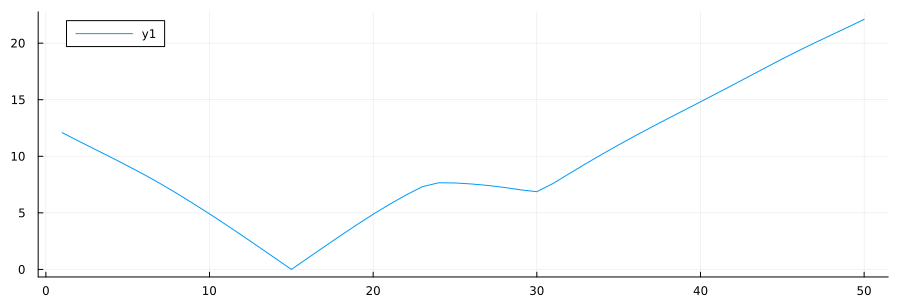

In [15]:
plot(dists[15,:])

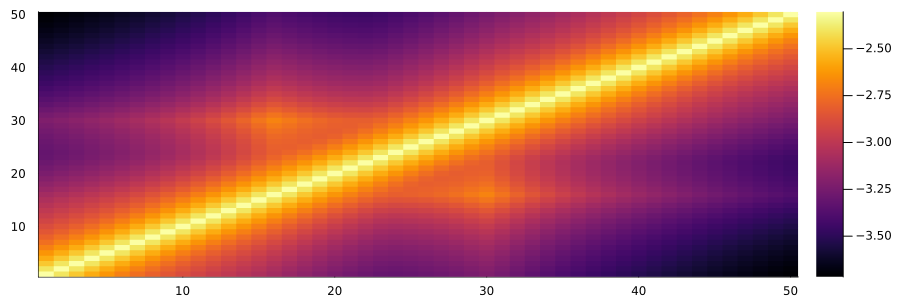

In [16]:
plot(heatmap(log.(contacts)))

In [17]:
length(dists_a_to_b)

20001

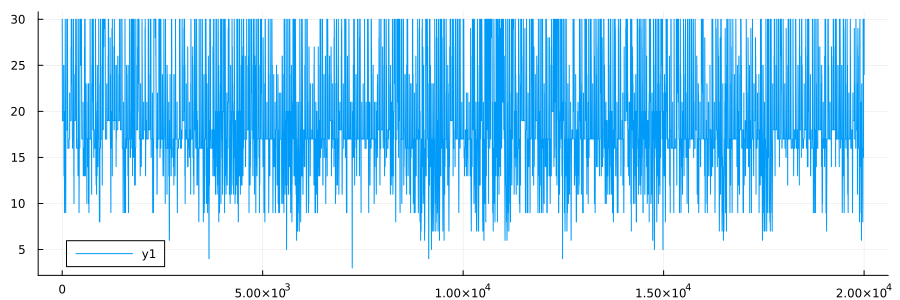

In [18]:
plot(1:20001, dists_a_to_b)

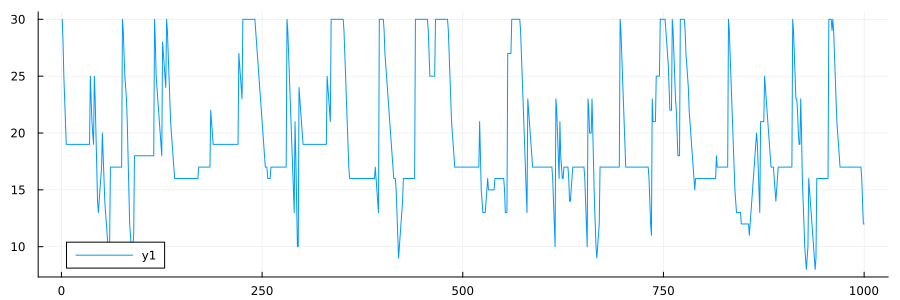

In [19]:
plot(1:1000, dists_a_to_b[1:1000])

Example:

bead 1: 127,721,000

bead 30: 127,750,000

bead size: 1,000 

CTCFS at:

    127,725,899 (bead 5) +
    
    127,734,115 (bead 14) +
    
    127,736,254 (bead 16) +
    
    127,737,853 (bead 17) +
    
    127,743,150 (bead 23) -
    

In [20]:
Random.seed!(1234)
object2 = Sim(2, 70e3, 10e3, 1000, 0.9, 4)

object2 = add_ctcf(object2, "+", 5000, 1)
object2 = add_ctcf(object2, "+", 14000, 1)
object2 = add_ctcf(object2, "+", 16000, 1)
object2 = add_ctcf(object2, "+", 17000, 1)
object2 = add_ctcf(object2, "-", 23000, 1)

object2



Cohesin positions: [23, 39]
Extruded beads: 0 of 70
Plus CTCF positions (bound fraction): [17000.0, 16000.0, 14000.0, 5000.0]([1.0, 1.0, 1.0, 1.0]) 
Minus CTCF positions (bound fraction): [23000.0]([1.0]) 
Individual cohesins:

Lived 0 of 10 - Anchors: 23, 23 - Extruded beads:Int64[]
Lived 5 of 10 - Anchors: 39, 39 - Extruded beads:Int64[]


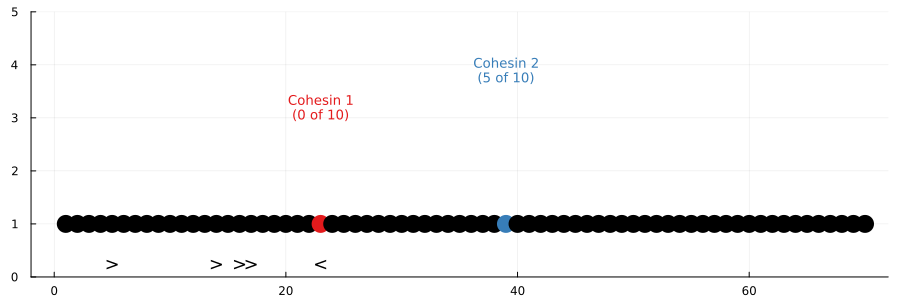

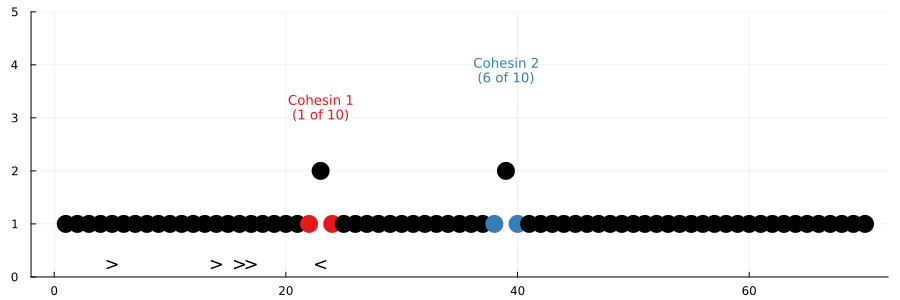

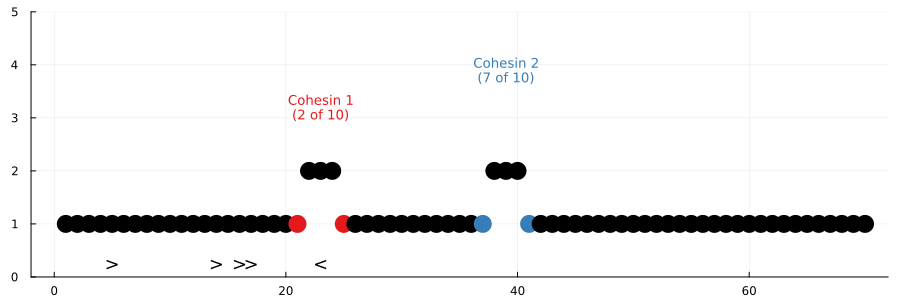

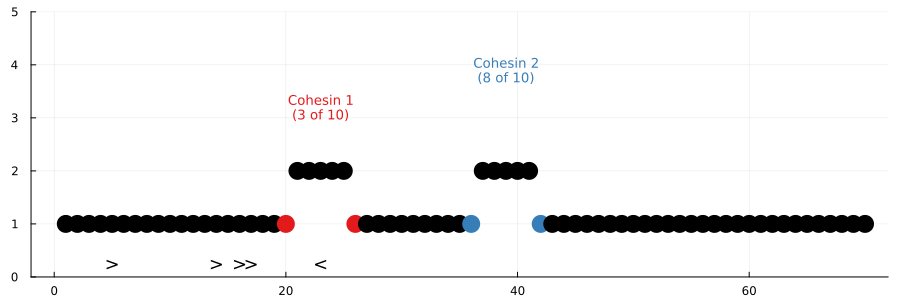

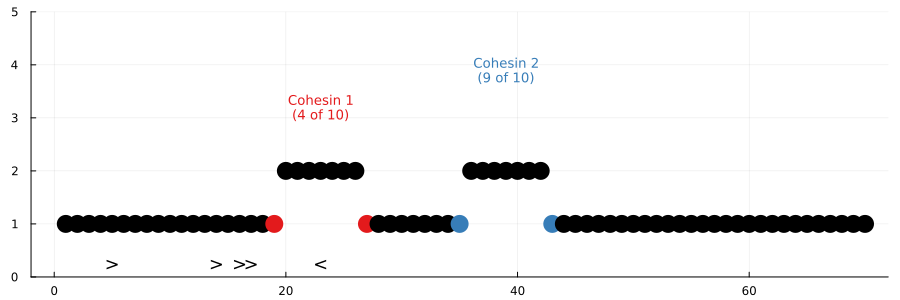

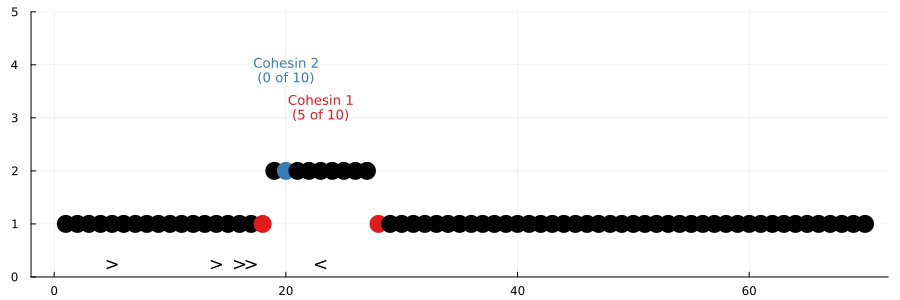

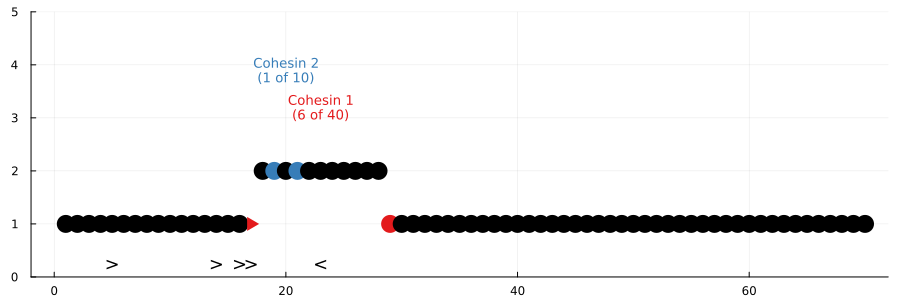

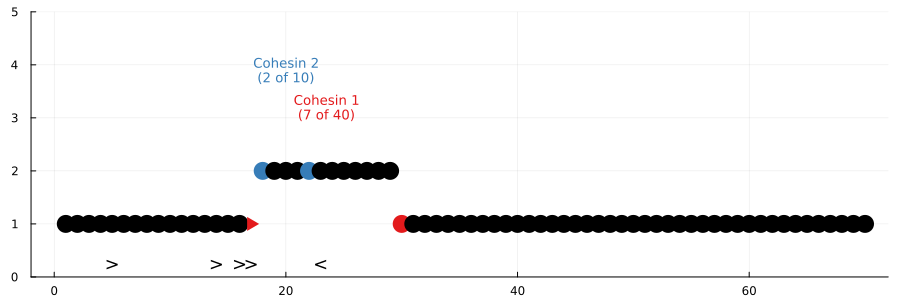

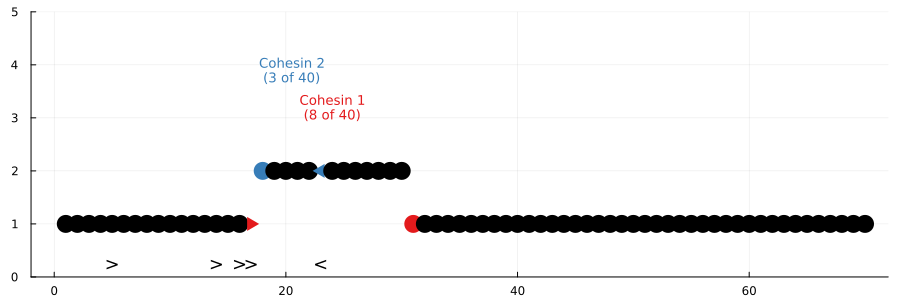

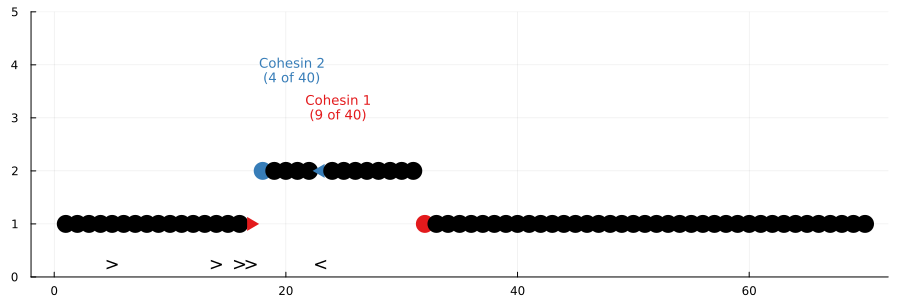

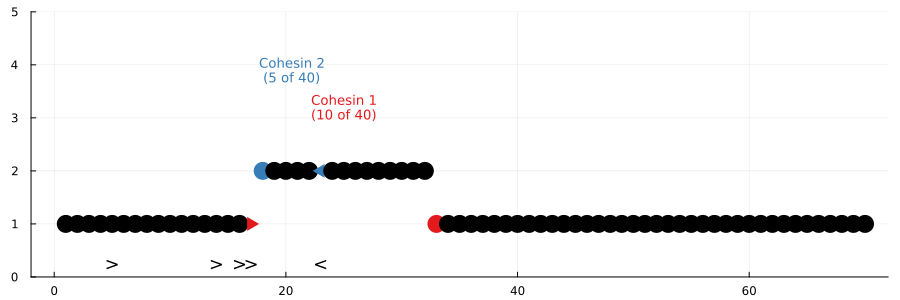

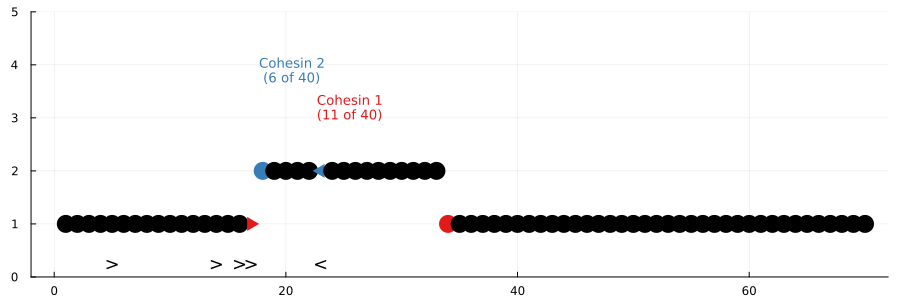

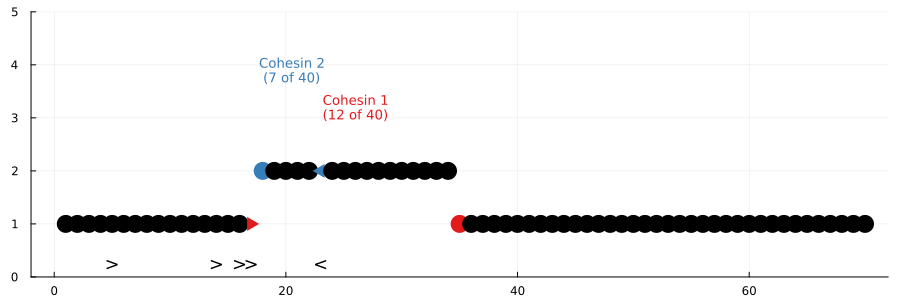

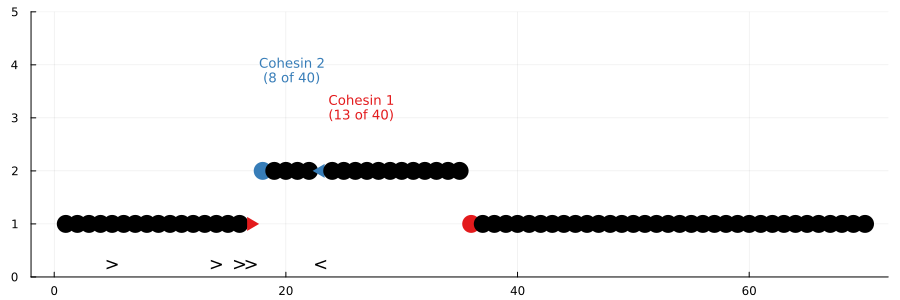

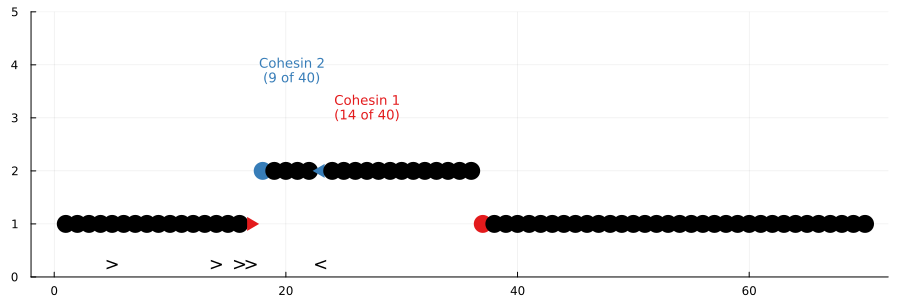

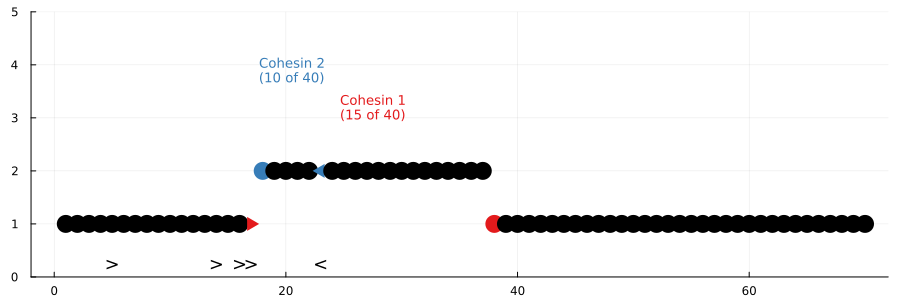

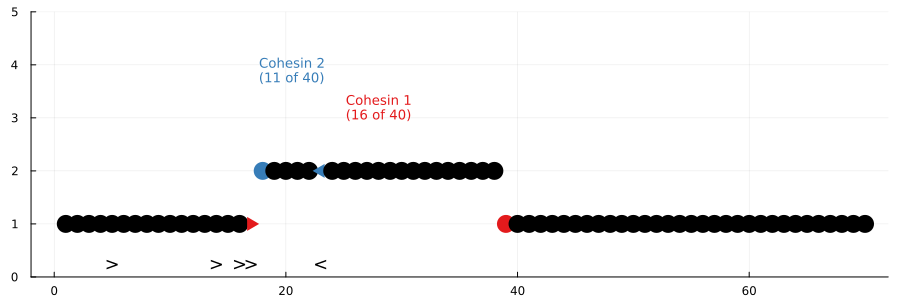

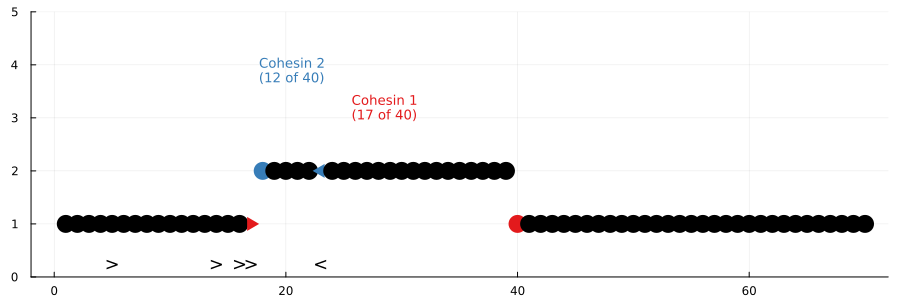

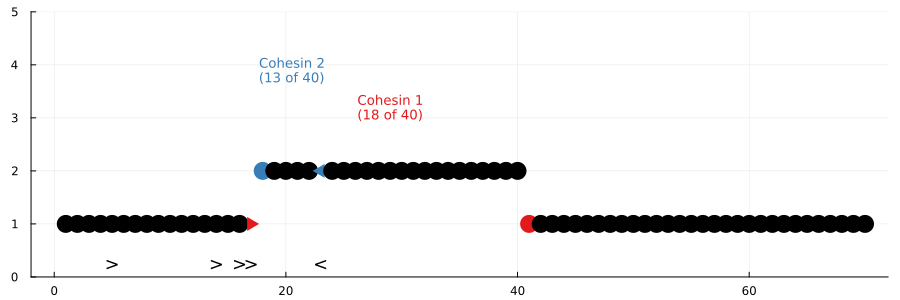

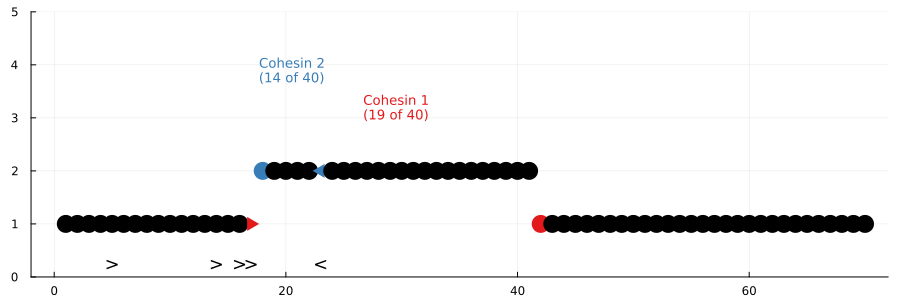

70×70 Matrix{Float64}:
 0.1        0.0909091  0.0833614  …  0.018681   0.0183843  0.018096
 0.0909091  0.1        0.0909091     0.0190055  0.0186978  0.0183992
 0.0833614  0.0909091  0.1           0.0193524  0.0190325  0.0187224
 0.0771514  0.083347   0.0909091     0.0197206  0.0193873  0.0190647
 0.0718208  0.0769982  0.0833432     0.0201128  0.019765   0.0194286
 0.0672646  0.0716201  0.0769565  …  0.0202064  0.0198576  0.0195203
 0.0633604  0.0670418  0.0715312     0.020309   0.0199586  0.0196196
 0.059953   0.0631139  0.0669133     0.0204315  0.0200783  0.0197367
 0.0569494  0.0597028  0.0629735     0.0205809  0.0202235  0.0198779
 0.0543126  0.0567523  0.0596176     0.0207646  0.0204012  0.0200499
 0.0519925  0.054191   0.0567502  …  0.0210433  0.0206688  0.0203073
 0.0501942  0.0522315  0.054584      0.0213652  0.0209774  0.0206036
 0.0487026  0.0506165  0.0528226     0.0217323  0.021329   0.0209409
 ⋮                                ⋱                        
 0.0220667  0.0225335

In [21]:
dists = effective_dist(object2)
contacts = (effective_dist(object2).+10).^(-1)
a=15
b=30
dists_a_to_b = [effective_dist(object2)[a,b]]
for i in 1:20000
    # plot the first 20 steps in the simulation
    if i<=20
        display(plot_fiber(object2))
    end
    advance(object2)
    dists = dists + effective_dist(object2)
    contacts = contacts + ((effective_dist(object2).+10).^(-1))
    dists_a_to_b = push!(dists_a_to_b, effective_dist(object2)[a,b])
end
dists = dists/20001
contacts = contacts/20001

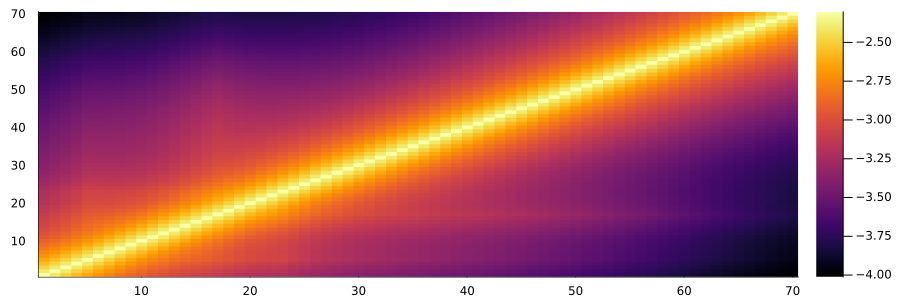

In [22]:
plot(heatmap(log.(contacts)))

Next Steps:   

time to run: compare against r code

histogram of distances